In [1]:
# 07b – Parametric Distribution Forecasting
# --------------------------------------------------------------
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Load demand and population data (paths same as 07a)
demand_path = Path("/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed/demand_distributions/modality_demand_by_age_and_source.csv")
pop_path = Path("/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/all_icbs_2024.csv")

demand_df = pd.read_csv(demand_path)
raw_df = pd.read_csv(pop_path)

# Reshape population wide → long format as before
age_columns = [col for col in raw_df.columns if col.startswith("age_")]
pop_long_df = raw_df.melt(
    id_vars=["lsoa21cd"],
    value_vars=age_columns,
    var_name="age_band",
    value_name="population"
)
pop_long_df["age"] = pop_long_df["age_band"].str.extract(r"age_(\d+)_?")[0].astype(int)
pop_long_df = pop_long_df[["lsoa21cd", "age", "population"]]

# We will model CT, MRI, Endoscopy separately.
modalities = demand_df['modality'].unique()

In [3]:
# Container for final forecast
final_forecast_list = []

Processing modality: CT
Fitted gamma params for CT: (8.836998895070366, 0, np.float64(7.405843444693302))
Processing modality: Endoscopy
Fitted gamma params for Endoscopy: (11.845215589165619, 0, np.float64(5.53250186272121))
Processing modality: MRI
Fitted gamma params for MRI: (5.019445345113841, 0, np.float64(10.739625246739719))


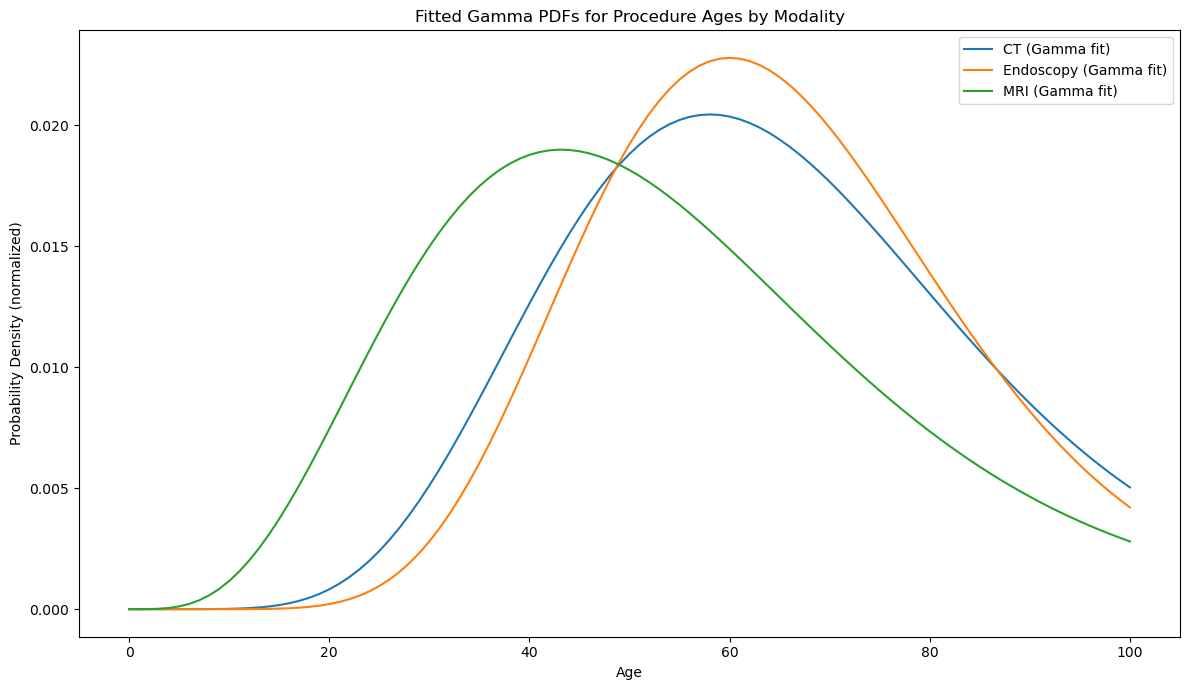

Parametric distribution forecast (head):


,lsoa_code,modality,pred_model_3
0,E01014014,CT,43.236380
1,E01014031,CT,38.249390
2,E01014032,CT,37.658741
3,E01014036,CT,41.912312
4,E01014053,CT,42.807413


In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

modalities = demand_df['modality'].unique()
final_forecast_list = []

plt.figure(figsize=(12, 7))
ages = np.arange(0, 101)

for mod in modalities:
    print(f"Processing modality: {mod}")

    df_mod = demand_df[demand_df['modality'] == mod].copy()  # avoid SettingWithCopyWarning
    df_mod['age'] = df_mod['age'].astype(int)
    df_mod['procedure_count'] = df_mod['procedure_count'].astype(int)

    expanded_ages = np.repeat(df_mod['age'], df_mod['procedure_count'])
    expanded_ages_pos = expanded_ages[expanded_ages > 0]

    if len(expanded_ages_pos) < 10:
        print(f"Insufficient positive ages for fitting for {mod}. Skipping.")
        continue

    gamma_params = stats.gamma.fit(expanded_ages_pos, floc=0)
    print(f"Fitted gamma params for {mod}: {gamma_params}")

    # Calculate gamma PDF for plotting
    pdf_vals = stats.gamma.pdf(ages, *gamma_params)
    pdf_vals /= pdf_vals.sum()  # normalize to sum to 1 for better visualization

    # Plot the Gamma PDF for this modality
    plt.plot(ages, pdf_vals, label=f'{mod} (Gamma fit)')

    total_demand = df_mod['procedure_count'].sum()

    national_pop_by_age = pop_long_df.groupby('age')['population'].sum()
    national_pop_by_age = national_pop_by_age.reindex(ages, fill_value=0)

    rate_per_age = np.zeros_like(ages, dtype=float)
    nonzero_pop = national_pop_by_age > 0
    rate_per_age[nonzero_pop] = (pdf_vals[nonzero_pop] * total_demand) / national_pop_by_age[nonzero_pop]

    mod_rate_df = pd.DataFrame({
        'age': ages,
        'modality': mod,
        'rate_per_1000': rate_per_age * 1000
    })

    pop_mod_df = pop_long_df.copy()
    pop_mod_df['modality'] = mod

    pop_mod = pd.merge(pop_mod_df, mod_rate_df, on=['age', 'modality'], how='left')
    pop_mod.loc[:, 'rate_per_1000'] = pop_mod['rate_per_1000'].fillna(0)
    pop_mod['expected_demand'] = (pop_mod['population'] * pop_mod['rate_per_1000']) / 1000

    lsoa_mod_forecast = pop_mod.groupby(['lsoa21cd', 'modality'], as_index=False)['expected_demand'].sum()
    lsoa_mod_forecast.rename(columns={'lsoa21cd': 'lsoa_code', 'expected_demand': 'pred_model_3'}, inplace=True)

    final_forecast_list.append(lsoa_mod_forecast)

plt.title("Fitted Gamma PDFs for Procedure Ages by Modality")
plt.xlabel("Age")
plt.ylabel("Probability Density (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

if final_forecast_list:
    final_forecast_df = pd.concat(final_forecast_list, ignore_index=True)
else:
    final_forecast_df = pd.DataFrame()

print("Parametric distribution forecast (head):")
display(final_forecast_df.head())


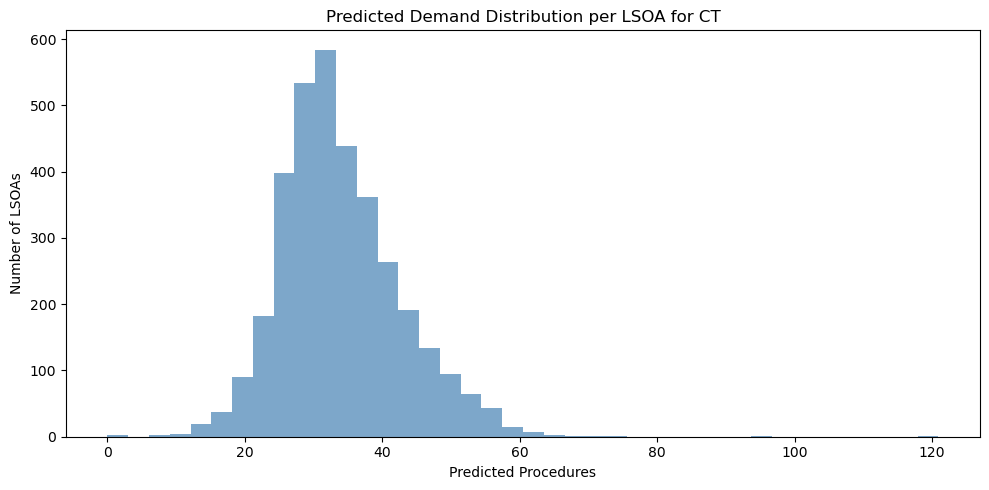

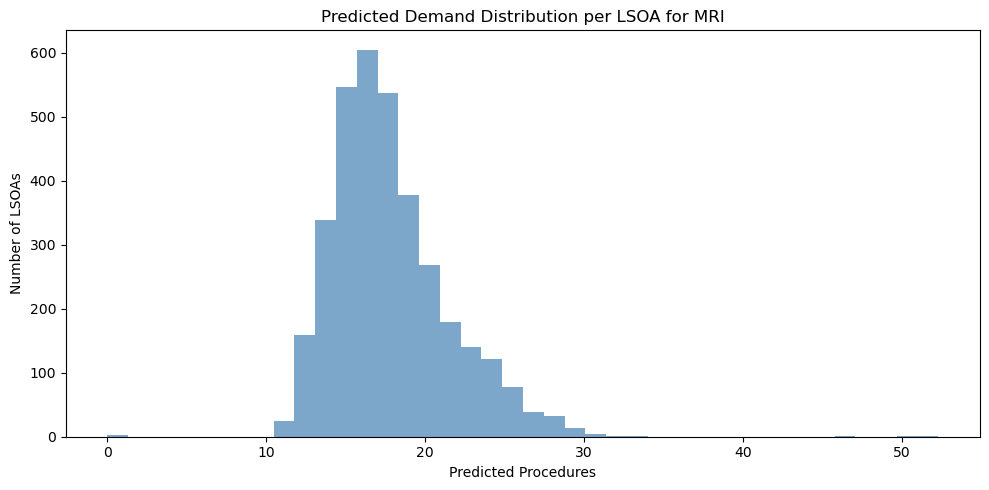

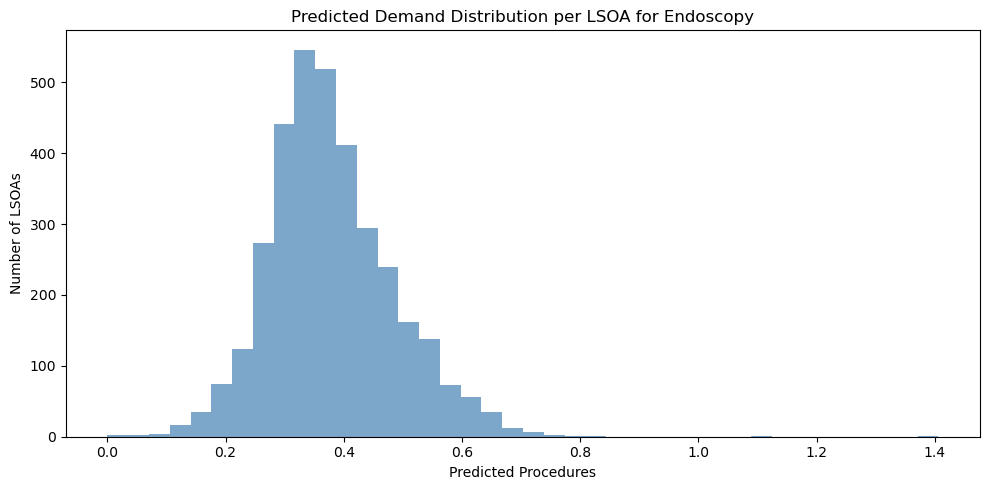

In [34]:
# --- Visualization for CT, MRI, Endoscopy ---

for mod in ['CT', 'MRI', 'Endoscopy']:
    df_plot = final_forecast_df[final_forecast_df['modality'] == mod]
    if df_plot.empty:
        print(f"No forecast data for modality {mod}. Skipping plot.")
        continue

    plt.figure(figsize=(10, 5))
    plt.hist(df_plot['pred_model_3'], bins=40, color='steelblue', alpha=0.7)
    plt.title(f'Predicted Demand Distribution per LSOA for {mod}')
    plt.xlabel('Predicted Procedures')
    plt.ylabel('Number of LSOAs')
    plt.tight_layout()
    plt.show()

Number of nulls in modality_clean: 3472
Unmapped modality values:
['Endoscopy']


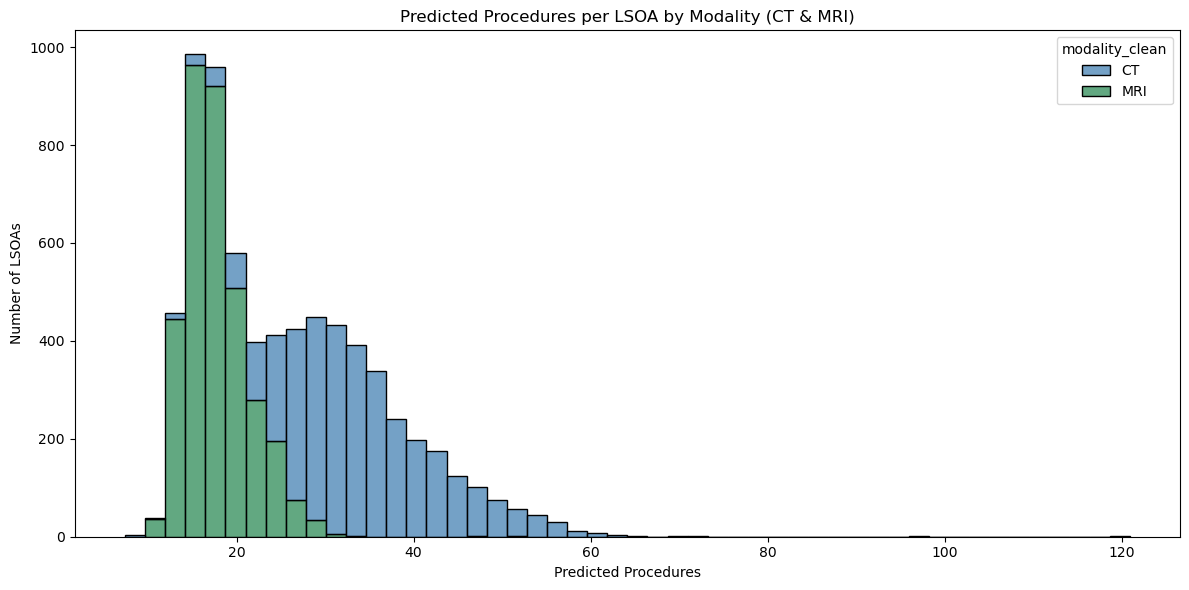

No referral_type column found; skipping faceted plot.


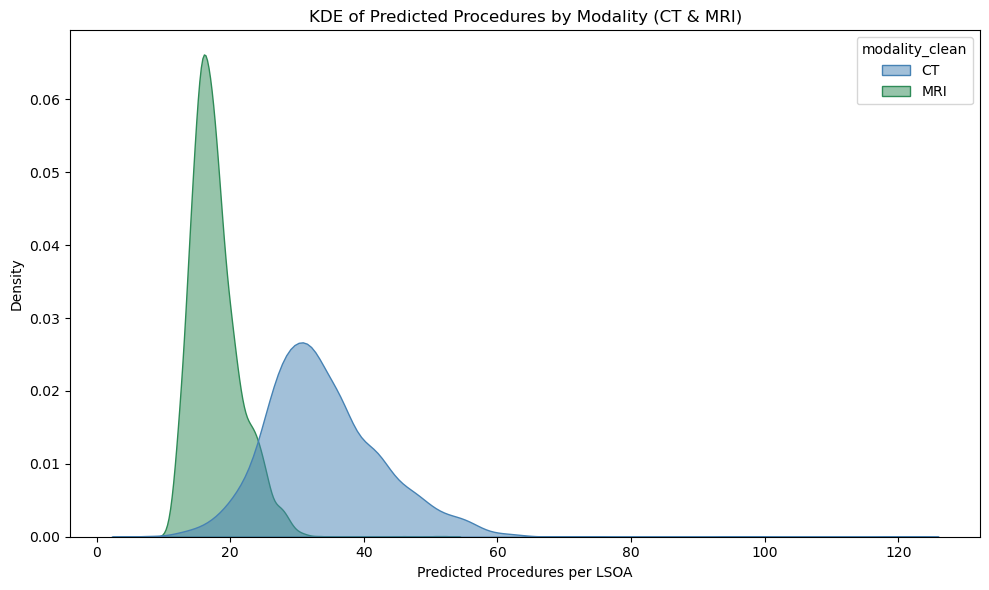

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your forecast dataframe is named final_forecast_df
# Map modalities for filtering (only CT and MRI)
modality_map = {
    'CT': 'CT',
    'MRI': 'MRI'
}

# Add a cleaned modality column for plotting
final_forecast_df['modality_clean'] = final_forecast_df['modality'].map(modality_map)

# Check for unmapped modalities (nulls in modality_clean)
num_null_mod = final_forecast_df['modality_clean'].isna().sum()
print(f"Number of nulls in modality_clean: {num_null_mod}")
if num_null_mod > 0:
    print("Unmapped modality values:")
    print(final_forecast_df.loc[final_forecast_df['modality_clean'].isna(), 'modality'].unique())

# Filter data to CT and MRI, remove zero or NaN predictions
plot_df = final_forecast_df.dropna(subset=['pred_model_3', 'modality_clean'])
plot_df = plot_df[plot_df['pred_model_3'] > 0]
plot_df = plot_df[plot_df['modality_clean'].isin(['CT', 'MRI'])]

if plot_df.empty:
    raise ValueError("Nothing to plot – plot_df is empty after filtering.")

# Define palette for CT and MRI
modality_palette = {
    'CT': 'steelblue',
    'MRI': 'seagreen'
}

# Histogram by modality
plt.figure(figsize=(12, 6))
sns.histplot(
    data=plot_df,
    x='pred_model_3',
    hue='modality_clean',
    palette=modality_palette,
    bins=50,
    multiple='stack'
)
plt.title("Predicted Procedures per LSOA by Modality (CT & MRI)")
plt.xlabel("Predicted Procedures")
plt.ylabel("Number of LSOAs")
plt.tight_layout()
plt.show()

# Faceted histogram by referral_type
# If referral_type is not in final_forecast_df, skip this part or adjust accordingly
if 'referral_type' in plot_df.columns:
    g = sns.displot(
        data=plot_df,
        x='pred_model_3',
        col='referral_type',
        hue='modality_clean',
        palette=modality_palette,
        col_wrap=3,
        bins=40,
        facet_kws={'sharex': False, 'sharey': False},
        height=4,
        aspect=1.2
    )
    g.set_titles("Referral: {col_name}")
    g.set_axis_labels("Predicted Procedures", "Count of LSOAs")
    plt.tight_layout()
    plt.show()
else:
    print("No referral_type column found; skipping faceted plot.")

# KDE plot by modality
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=plot_df,
    x='pred_model_3',
    hue='modality_clean',
    palette=modality_palette,
    fill=True,
    alpha=0.5
)
plt.title("KDE of Predicted Procedures by Modality (CT & MRI)")
plt.xlabel("Predicted Procedures per LSOA")
plt.ylabel("Density")
plt.tight_layout()
plt.show()
